In [1]:
import yfinance as yf
import numpy as np
import matplotlib as plt
import pandas as pd
from scipy.optimize import Bounds
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

## Downloading Adjusted Close Data for MSFT,AAPL, & NVDA tickers

In [2]:
tickers = ['MSFT','AAPL','NVDA']

In [3]:
df = yf.download(tickers,start='2024-01-1', end='2024-10-17',interval='1d')['Adj Close']

[*********************100%***********************]  3 of 3 completed


In [486]:
ret_df = np.log(df/df.shift(1))
ret_df

Ticker,AAPL,MSFT,NVDA
Date,,,
2024-01-02,NaN,NaN,NaN
2024-01-03,-0.007516,-0.000728,-0.012514
2024-01-04,-0.012781,-0.007203,0.008978
2024-01-05,-0.004021,-0.000517,0.022638
2024-01-08,0.023887,0.018696,0.062299
...,...,...,...
2024-10-10,-0.002181,-0.003888,0.016152
2024-10-11,-0.006527,0.001154,-0.000074
2024-10-14,0.016346,0.006751,0.023969


## Scatter matrix plot of the three stocks: 

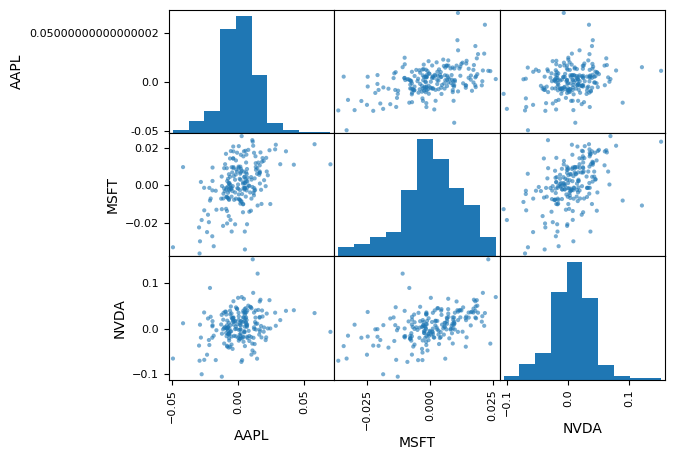

In [325]:
pd.plotting.scatter_matrix(ret_df,alpha = 0.6);

## Correlation Plot of the three stocks: 

C:\Users\hamad\AppData\Local\Temp\ipykernel_10912\1261348413.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['']+tickers);
C:\Users\hamad\AppData\Local\Temp\ipykernel_10912\1261348413.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['']+tickers);


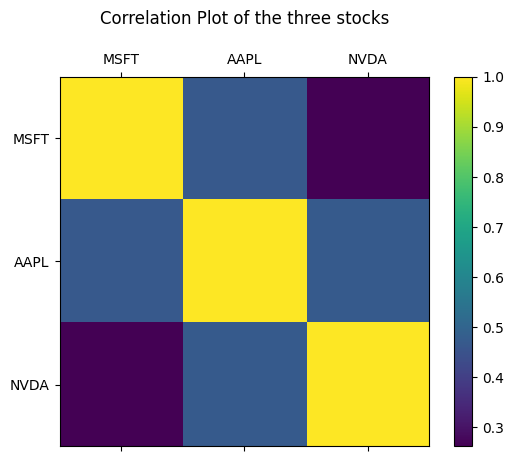

In [484]:
figure = plt.figure()
axes = figure.add_subplot(111)
 
# using the matshow() function 
caxes = axes.matshow(ret_df.corr(), interpolation ='nearest')
figure.colorbar(caxes)
 
axes.set_xticklabels(['']+tickers);
axes.set_yticklabels(['']+tickers);
plt.title("Correlation Plot of the three stocks\n")
plt.show();

### Mean & Standard Deviation of log returns of the three stocks:

In [8]:
print("\nMean of log returns: \n\n",ret_df.mean(),"\n")
print("Standard deviation of log returns: \n\n", ret_df.std())


Mean of log returns: 

 Ticker
AAPL    0.001135
MSFT    0.000606
NVDA    0.005207
dtype: float64 

Standard deviation of log returns: 

 Ticker
AAPL    0.014931
MSFT    0.012186
NVDA    0.034985
dtype: float64


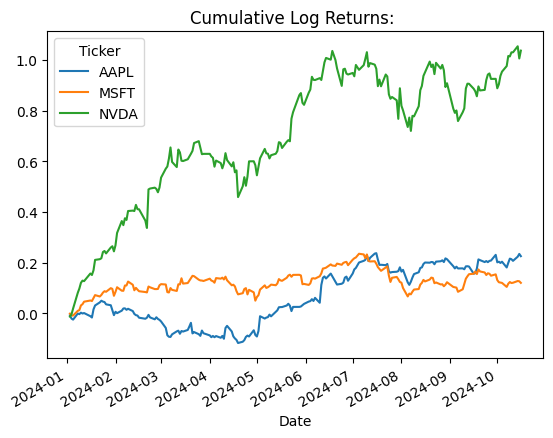

In [479]:
ret_df.iloc[:,].cumsum().plot(title = "Cumulative Log Returns: ");

In [275]:
W = np.ones(len(ret_df.columns))/np.ones(len(ret_df.columns)).sum()

In [11]:
def sharpe(W,returns):
    pf_risk = ((W.dot(returns.cov())).dot(W)) ** 0.5
    SR = W.dot(returns.mean())/pf_risk
    return -SR

## Sharpe Ratio of Portfolio using equal weights:

In [12]:
sharpe(W,ret_df)

-0.14056243809216973

## Expected return of portfolio containing equal weights for the three stocks:

In [13]:
ret_df.mean().dot(W)

0.002315666578879068

## Optimizing weights to reduce Sharpe Ratio

In [14]:
cons = ({"type":"eq","fun": lambda x: np.sum(x)-1})

In [327]:
opt_w = minimize(sharpe,W,ret_df,bounds = Bounds(0,1),constraints = cons)

In [300]:
print(opt_w.x)

[0.39927461 0.         0.60072539]


## Sharpe Ratio of Portfolio with Optimized weights:

In [328]:
print(sharpe(opt_w.x,ret_df))

-0.15365637567938248


## Expected return of portflio given optimized weights; 

In [16]:
opt_w.x.dot(ret_df.mean())

0.0035807171929123317

## Loading 207 Days of Adjusted Close Data for MSFT,AAPL, & NVDA tickers

In [17]:
tickers_dj = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average',match = 'DJIA component companies')

In [18]:
data_dj = yf.download(tickers_dj[0].Symbol.to_list(),start='2024-01-1', end='2024-10-28',interval='1d')['Adj Close'].dropna(axis=1,how="all")

[*********************100%***********************]  28 of 30 completed

3 Failed downloads:
[*********************100%***********************]  28 of 30 completed['HD', 'MCD', 'TRV']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))


In [20]:
 device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [476]:
data1 = data_dj[['MSFT','AAPL','NVDA']].iloc[176:]
final_3mo_return = np.log(data1/data1.shift(1))

30

# Forecasting Adjusted Close Prices Using LSTM Modeling:

### - Preparing Dataframe for LSTM model Input:

In [21]:
def prepare_dataframe_for_lstm(df,n_steps):
    df = dc(df)


    for i in range(1,n_steps+1):
        df[f'adj close(t-{i})'] = df[df.columns[0]].shift(i)

    df.dropna(inplace=True)
    return df

In [332]:
df_MSFT = data_dj[['MSFT']]

In [333]:
MSFT_lstm = prepare_dataframe_for_lstm(df_MSFT,7)
print(len(MSFT_lstm))

200


### - Normalizing Data and Creating Train and Test Datasets for Model Training

In [334]:
scaler = MinMaxScaler(feature_range = (-1,1))

In [335]:
norm_MSFT_lstm = scaler.fit_transform(MSFT_lstm)

In [336]:
X = norm_MSFT_lstm[:,1:]
X = dc(np.flip(X,axis=1))
Y = norm_MSFT_lstm[:,0]

In [337]:
split_index = int(len(X)*0.8)

In [338]:
X_train = X[:split_index]
X_test = X[split_index:]

Y_train = Y[:split_index]
Y_test = Y[split_index:]

np.shape(X_train),np.shape(X_test),np.shape(Y_train),np.shape(Y_test)

((160, 7), (40, 7), (160,), (40,))

In [339]:
lookback = 7
X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

Y_train = Y_train.reshape((-1,1))
Y_test = Y_test.reshape((-1,1))

X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((160, 7, 1), (40, 7, 1), (160, 1), (40, 1))

In [340]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

Y_train = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()



In [341]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self,i):
        return self.X[i],self.y[i]

train_dataset = TimeSeriesDataset(X_train,Y_train)
test_dataset = TimeSeriesDataset(X_test,Y_test)

In [342]:
from torch.utils.data import DataLoader

batch_size = 20

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

### - LSTM Model Architecture

In [343]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size,hidden_size,num_stacked_layers,batch_first=True)

        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out

model = LSTM(1,4,1)
model.to(device)


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [344]:
def validate_one_epoch(model,test_loader,val_losses):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch,y_batch = batch[0].to(device),batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output,y_batch)
            running_loss += loss.item()
            

    avg_loss_across_batches = running_loss / len(test_loader)
    val_losses.append(avg_loss_across_batches)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('**************************************************')
    print()

In [345]:
def train_one_epoch(model,train_loader,train_losses):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    train_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch,y_batch = batch[0].to(device),batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output,y_batch)
        running_loss += loss.item()
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 3 == 2:
            avg_loss_across_batches = running_loss / 3
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,avg_loss_across_batches))
            running_loss = 0.0
    train_losses.append(train_loss/len(train_loader))

    print()
        

### - Training LSTM Model On MSFT Dataframe

In [346]:
learning_rate = 0.01
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
MSFT_val_losses = []
MSFT_train_losses = []

for epoch in range(num_epochs):
    train_one_epoch(model,train_loader,MSFT_train_losses)
    validate_one_epoch(model,test_loader,MSFT_val_losses)

Epoch: 1
Batch 3, Loss: 0.247
Batch 6, Loss: 0.176

Val Loss: 0.042
**************************************************

Epoch: 2
Batch 3, Loss: 0.158
Batch 6, Loss: 0.174

Val Loss: 0.054
**************************************************

Epoch: 3
Batch 3, Loss: 0.133
Batch 6, Loss: 0.136

Val Loss: 0.047
**************************************************

Epoch: 4
Batch 3, Loss: 0.113
Batch 6, Loss: 0.121

Val Loss: 0.029
**************************************************

Epoch: 5
Batch 3, Loss: 0.096
Batch 6, Loss: 0.084

Val Loss: 0.022
**************************************************

Epoch: 6
Batch 3, Loss: 0.061
Batch 6, Loss: 0.038

Val Loss: 0.022
**************************************************

Epoch: 7
Batch 3, Loss: 0.026
Batch 6, Loss: 0.033

Val Loss: 0.028
**************************************************

Epoch: 8
Batch 3, Loss: 0.027
Batch 6, Loss: 0.025

Val Loss: 0.020
**************************************************

Epoch: 9
Batch 3, Loss: 0.026
Batch 6, L

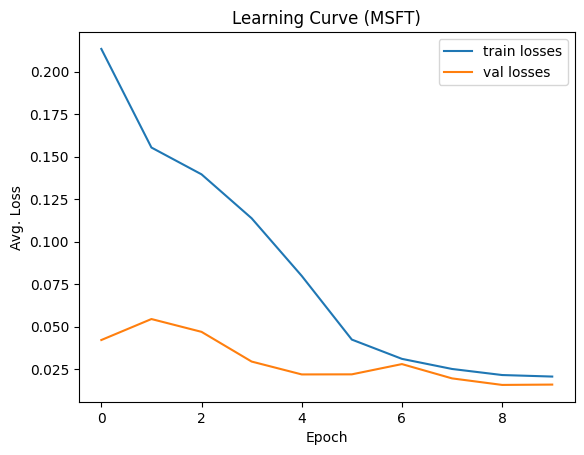

In [376]:
plt.plot(MSFT_train_losses, label = 'train losses')
plt.plot(MSFT_val_losses, label='val losses')
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss')
plt.title('Learning Curve (MSFT)')
plt.legend()
plt.show;

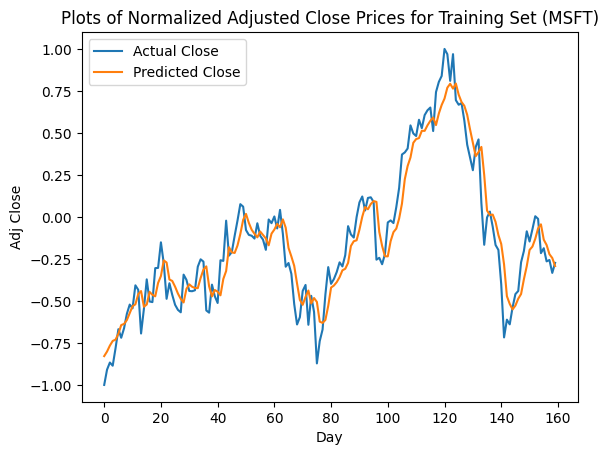

In [377]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(Y_train, label = 'Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.title("Plots of Normalized Adjusted Close Prices for Training Set (MSFT)")
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show;

In [350]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:,0])

In [351]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0] = Y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:,0])

<function matplotlib.pyplot.show(close=None, block=None)>

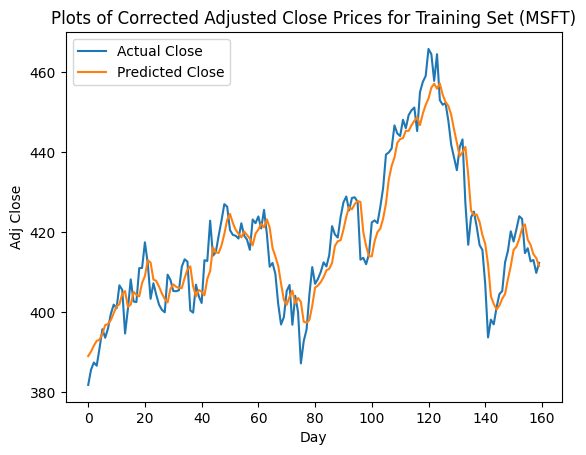

In [378]:
plt.plot(new_y_train, label = 'Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.title("Plots of Corrected Adjusted Close Prices for Training Set (MSFT)")
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show

In [353]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:,0])

In [354]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0] = Y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:,0])

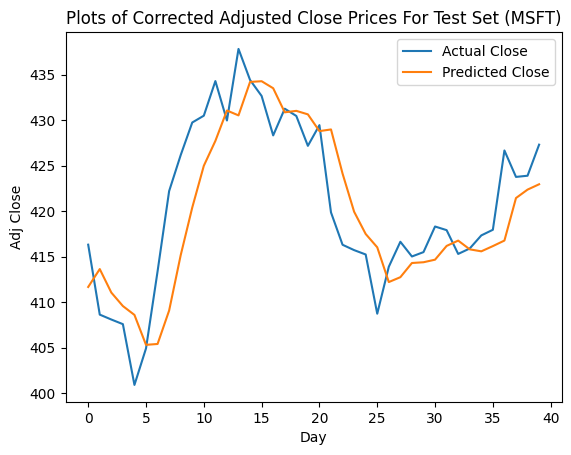

In [379]:
plt.plot(new_y_test, label = 'Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.title("Plots of Corrected Adjusted Close Prices For Test Set (MSFT)")
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show;

In [367]:
np.shape(norm_MSFT_lstm)



pred_next_month = dc(norm_MSFT_lstm[170,1:])
#print(np.shape(pred_next_month))

for i in range(len(norm_MSFT_lstm[170:,:])):
    pred_next_month = pred_next_month.reshape(1,-1)
    X = np.concatenate(((pred_next_month[0,i:i+7]).reshape(1,-1),np.zeros((1,7))))
    X = dc(np.flip(X,axis=1))
    lookback = 7
    X=X.reshape((-1,lookback,1))
    X = torch.tensor(X).float()

    day_predictions = model(X.to(device)).detach().cpu().numpy().flatten()
    
    pred_next_month = np.append(pred_next_month,day_predictions[0])

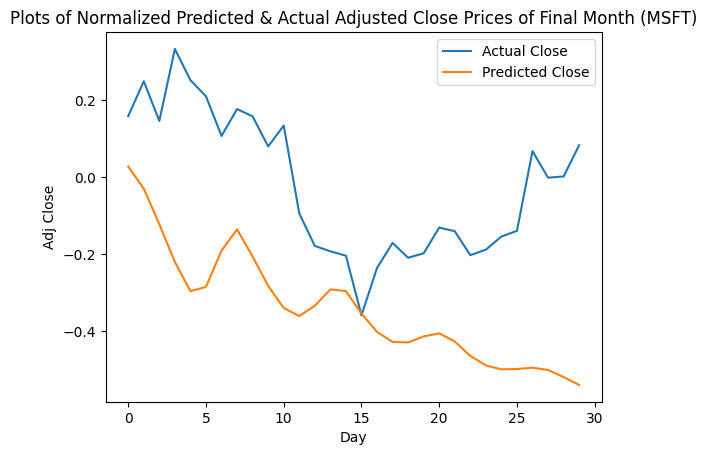

In [380]:
plt.plot(norm_MSFT_lstm[170:,0], label = 'Actual Close')
plt.plot(pred_next_month[7:], label='Predicted Close')
plt.title("Plots of Normalized Predicted & Actual Adjusted Close Prices of Final Month (MSFT)")
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show;

In [369]:
new_norm_MSFT = np.concatenate((norm_MSFT_lstm[110:170,0],pred_next_month[7:]))

In [370]:
dummies = np.zeros((new_norm_MSFT.shape[0], lookback+1))
dummies[:,0] = new_norm_MSFT
print(np.shape(dummies))
dummies = scaler.inverse_transform(dummies)

new_MSFT = dc(dummies[:,0])

(90, 8)


90


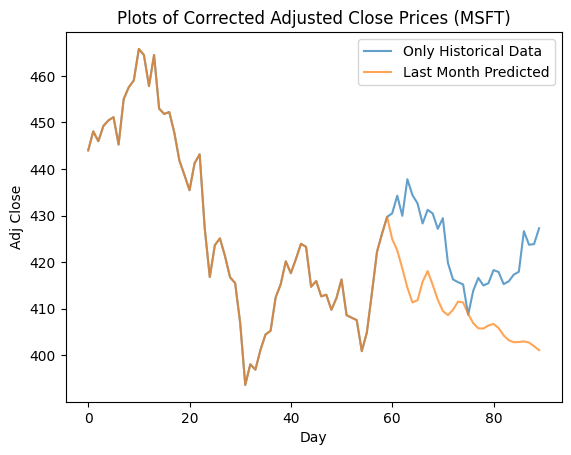

In [381]:
MSFT_lstm_actual = MSFT_lstm.iloc[110:,0].to_numpy()
print(len(new_MSFT))
plt.plot(MSFT_lstm_actual, label = 'Only Historical Data',alpha=0.7)
plt.plot(new_MSFT, label='Last Month Predicted',alpha=0.7)
plt.title("Plots of Corrected Adjusted Close Prices (MSFT)")
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show;

### - Repeating Same Process for AAPL Ticker: 

In [383]:
df_AAPL = data_dj[['AAPL']]

In [384]:
AAPL_lstm = prepare_dataframe_for_lstm(df_AAPL,7)

In [385]:
scaler2 = MinMaxScaler(feature_range = (-1,1))

In [386]:
norm_AAPL_lstm = scaler2.fit_transform(AAPL_lstm)

In [387]:
X = norm_AAPL_lstm[:,1:]
X = dc(np.flip(X,axis=1))
Y = norm_AAPL_lstm[:,0]

In [388]:
X_train = X[:split_index]
X_test = X[split_index:]

Y_train = Y[:split_index]
Y_test = Y[split_index:]

np.shape(X_train),np.shape(X_test),np.shape(Y_train),np.shape(Y_test)

((160, 7), (40, 7), (160,), (40,))

In [389]:
lookback = 7
X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

Y_train = Y_train.reshape((-1,1))
Y_test = Y_test.reshape((-1,1))

X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((160, 7, 1), (40, 7, 1), (160, 1), (40, 1))

In [390]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

Y_train = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()

In [391]:
train_dataset = TimeSeriesDataset(X_train,Y_train)
test_dataset = TimeSeriesDataset(X_test,Y_test)

In [392]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [393]:
model_AAPL = LSTM(1,4,1)
model_AAPL.to(device)

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [394]:
learning_rate = 0.01
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_AAPL.parameters(),lr=learning_rate)
AAPL_val_losses = []
AAPL_train_losses = []

for epoch in range(num_epochs):
    train_one_epoch(model_AAPL,train_loader,AAPL_train_losses)
    validate_one_epoch(model_AAPL,test_loader,AAPL_val_losses)

Epoch: 1
Batch 3, Loss: 0.392
Batch 6, Loss: 0.294

Val Loss: 0.727
**************************************************

Epoch: 2
Batch 3, Loss: 0.271
Batch 6, Loss: 0.216

Val Loss: 0.486
**************************************************

Epoch: 3
Batch 3, Loss: 0.171
Batch 6, Loss: 0.111

Val Loss: 0.143
**************************************************

Epoch: 4
Batch 3, Loss: 0.048
Batch 6, Loss: 0.034

Val Loss: 0.017
**************************************************

Epoch: 5
Batch 3, Loss: 0.031
Batch 6, Loss: 0.039

Val Loss: 0.018
**************************************************

Epoch: 6
Batch 3, Loss: 0.029
Batch 6, Loss: 0.025

Val Loss: 0.040
**************************************************

Epoch: 7
Batch 3, Loss: 0.020
Batch 6, Loss: 0.027

Val Loss: 0.056
**************************************************

Epoch: 8
Batch 3, Loss: 0.024
Batch 6, Loss: 0.021

Val Loss: 0.032
**************************************************

Epoch: 9
Batch 3, Loss: 0.020
Batch 6, L

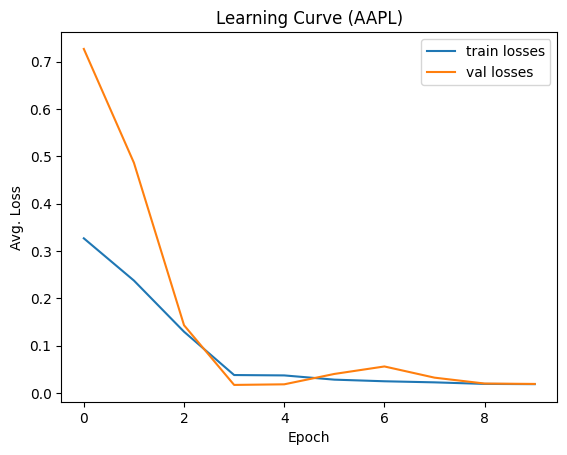

In [405]:
plt.plot(AAPL_train_losses, label = 'train losses')
plt.plot(AAPL_val_losses, label='val losses')
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss')
plt.title('Learning Curve (AAPL)')
plt.legend()
plt.show;

In [396]:
test_predictions = model_AAPL(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0] = test_predictions
dummies = scaler2.inverse_transform(dummies)

test_predictions = dc(dummies[:,0])

In [397]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0] = Y_test.flatten()
dummies = scaler2.inverse_transform(dummies)

new_y_test = dc(dummies[:,0])

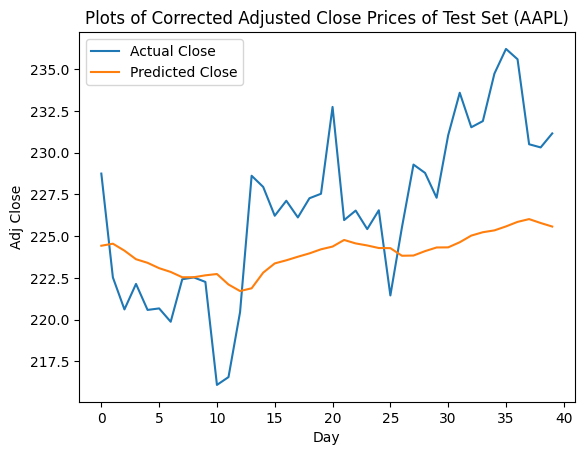

In [400]:
plt.plot(new_y_test, label = 'Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.title("Plots of Corrected Adjusted Close Prices of Test Set (AAPL)")
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show;

In [401]:
np.shape(norm_AAPL_lstm)



pred_next_month = dc(norm_AAPL_lstm[170,1:])
#print(np.shape(pred_next_month))

for i in range(len(norm_AAPL_lstm[170:,:])):
    pred_next_month = pred_next_month.reshape(1,-1)
    X = np.concatenate(((pred_next_month[0,i:i+7]).reshape(1,-1),np.zeros((1,7))))
    X = dc(np.flip(X,axis=1))
    lookback = 7
    X=X.reshape((-1,lookback,1))
    X = torch.tensor(X).float()

    day_predictions = model(X.to(device)).detach().cpu().numpy().flatten()
    
    pred_next_month = np.append(pred_next_month,day_predictions[0])

In [402]:
new_norm_AAPL = np.concatenate((norm_AAPL_lstm[110:170,0],pred_next_month[7:]))

In [403]:
dummies = np.zeros((new_norm_AAPL.shape[0], lookback+1))
dummies[:,0] = new_norm_AAPL
print(np.shape(dummies))
dummies = scaler2.inverse_transform(dummies)

new_AAPL = dc(dummies[:,0])

(90, 8)


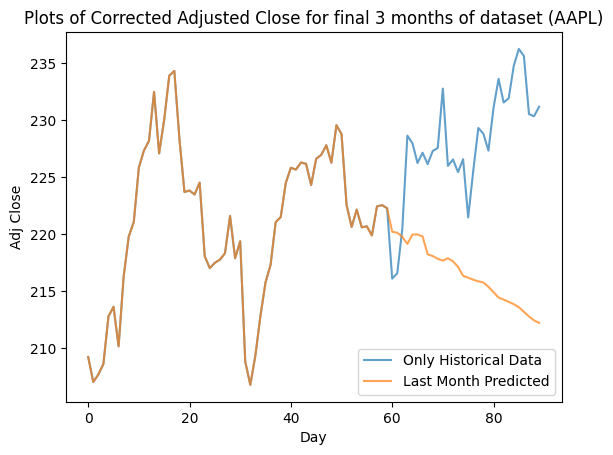

In [404]:
AAPL_lstm_actual = AAPL_lstm.iloc[110:,0].to_numpy()
plt.plot(AAPL_lstm_actual, label = 'Only Historical Data',alpha=0.7)
plt.plot(new_AAPL, label='Last Month Predicted',alpha=0.7)
plt.title("Plots of Corrected Adjusted Close for final 3 months of dataset (AAPL)")
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show;

### - Repeating Same Process for NVDA ticker:

In [406]:
df_NVDA = data_dj[['NVDA']]

In [407]:
NVDA_lstm = prepare_dataframe_for_lstm(df_NVDA,7)

In [408]:
scaler3 = MinMaxScaler(feature_range = (-1,1))

In [409]:
norm_NVDA_lstm = scaler3.fit_transform(NVDA_lstm)

In [410]:
X = norm_NVDA_lstm[:,1:]
X = dc(np.flip(X,axis=1))
Y = norm_NVDA_lstm[:,0]

In [411]:
X_train = X[:split_index]
X_test = X[split_index:]

Y_train = Y[:split_index]
Y_test = Y[split_index:]

np.shape(X_train),np.shape(X_test),np.shape(Y_train),np.shape(Y_test)

((160, 7), (40, 7), (160,), (40,))

In [412]:
lookback = 7
X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

Y_train = Y_train.reshape((-1,1))
Y_test = Y_test.reshape((-1,1))

X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((160, 7, 1), (40, 7, 1), (160, 1), (40, 1))

In [413]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

Y_train = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()

In [414]:
train_dataset = TimeSeriesDataset(X_train,Y_train)
test_dataset = TimeSeriesDataset(X_test,Y_test)

In [415]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [416]:
model_NVDA = LSTM(1,4,1)
model_NVDA.to(device)

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [417]:
learning_rate = 0.01
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_NVDA.parameters(),lr=learning_rate)
NVDA_val_losses = []
NVDA_train_losses = []

for epoch in range(num_epochs):
    train_one_epoch(model_NVDA,train_loader,NVDA_train_losses)
    validate_one_epoch(model_NVDA,test_loader,NVDA_val_losses)

Epoch: 1
Batch 3, Loss: 0.205
Batch 6, Loss: 0.277

Val Loss: 0.470
**************************************************

Epoch: 2
Batch 3, Loss: 0.177
Batch 6, Loss: 0.155

Val Loss: 0.193
**************************************************

Epoch: 3
Batch 3, Loss: 0.097
Batch 6, Loss: 0.060

Val Loss: 0.084
**************************************************

Epoch: 4
Batch 3, Loss: 0.019
Batch 6, Loss: 0.019

Val Loss: 0.039
**************************************************

Epoch: 5
Batch 3, Loss: 0.028
Batch 6, Loss: 0.017

Val Loss: 0.037
**************************************************

Epoch: 6
Batch 3, Loss: 0.012
Batch 6, Loss: 0.010

Val Loss: 0.042
**************************************************

Epoch: 7
Batch 3, Loss: 0.016
Batch 6, Loss: 0.012

Val Loss: 0.039
**************************************************

Epoch: 8
Batch 3, Loss: 0.011
Batch 6, Loss: 0.012

Val Loss: 0.032
**************************************************

Epoch: 9
Batch 3, Loss: 0.010
Batch 6, L

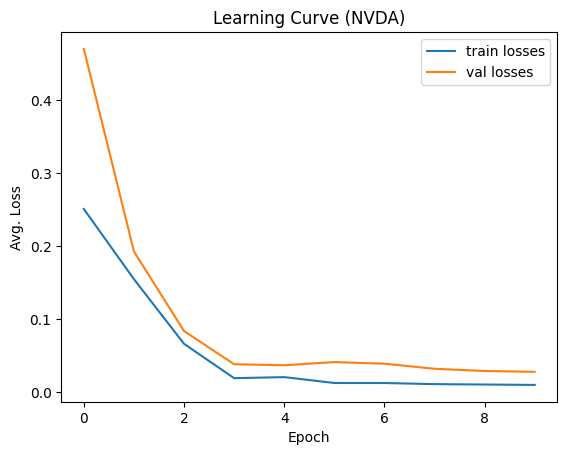

In [419]:
plt.plot(NVDA_train_losses, label = 'train losses')
plt.plot(NVDA_val_losses, label='val losses')
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss')
plt.title('Learning Curve (NVDA)')
plt.legend()
plt.show;

In [421]:
test_predictions = model_NVDA(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0] = test_predictions
dummies = scaler3.inverse_transform(dummies)

test_predictions = dc(dummies[:,0])

In [422]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0] = Y_test.flatten()
dummies = scaler3.inverse_transform(dummies)

new_y_test = dc(dummies[:,0])

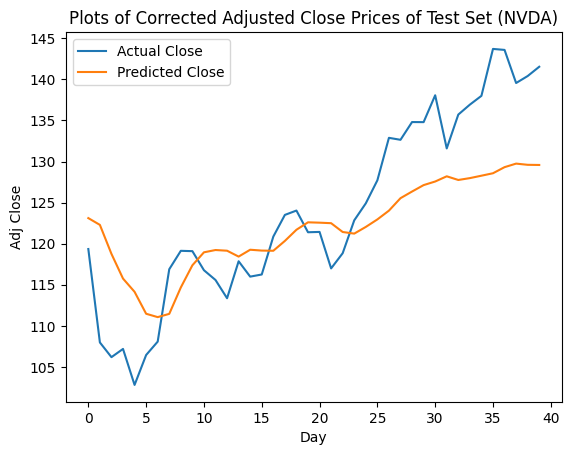

In [449]:
plt.plot(new_y_test, label = 'Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.title("Plots of Corrected Adjusted Close Prices of Test Set (NVDA)")
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show;

In [424]:
pred_next_month = dc(norm_NVDA_lstm[170,1:])
#print(np.shape(pred_next_month))

for i in range(len(norm_NVDA_lstm[170:,:])):
    pred_next_month = pred_next_month.reshape(1,-1)
    X = np.concatenate(((pred_next_month[0,i:i+7]).reshape(1,-1),np.zeros((1,7))))
    X = dc(np.flip(X,axis=1))
    lookback = 7
    X=X.reshape((-1,lookback,1))
    X = torch.tensor(X).float()

    day_predictions = model(X.to(device)).detach().cpu().numpy().flatten()
    
    pred_next_month = np.append(pred_next_month,day_predictions[0])

In [425]:
new_norm_NVDA = np.concatenate((norm_NVDA_lstm[110:170,0],pred_next_month[7:]))

In [426]:
dummies = np.zeros((new_norm_NVDA.shape[0], lookback+1))
dummies[:,0] = new_norm_NVDA
print(np.shape(dummies))
dummies = scaler3.inverse_transform(dummies)

new_NVDA = dc(dummies[:,0])

(90, 8)


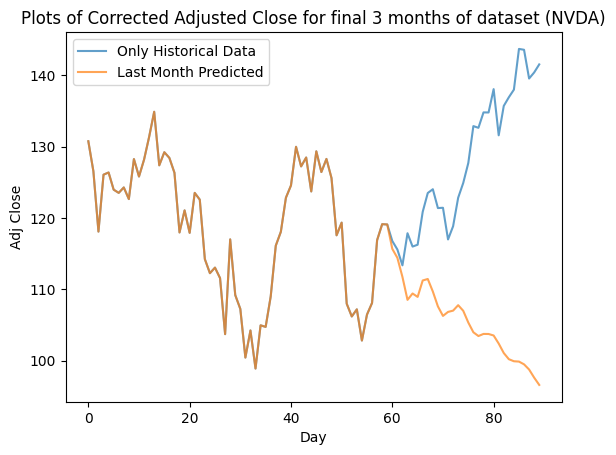

In [448]:
NVDA_lstm_actual = NVDA_lstm.iloc[110:,0].to_numpy()
plt.plot(NVDA_lstm_actual, label = 'Only Historical Data',alpha=0.7)
plt.plot(new_NVDA, label='Last Month Predicted',alpha=0.7)
plt.title("Plots of Corrected Adjusted Close for final 3 months of dataset (NVDA)")
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show;

## Generating Log Return Dataframes for Our two datasets of Adjusted Close Prices:

In [430]:
MSFT_3mo = NVDA_lstm.iloc[80:170,0].to_numpy()
new_MSFT;
AAPL_3mo = NVDA_lstm.iloc[80:170,0].to_numpy()
new_AAPL;
NVDA_3mo = NVDA_lstm.iloc[80:170,0].to_numpy()
new_NVDA;

In [431]:
data = {'MSFT_3mo': MSFT_3mo, 'AAPL_3mo': AAPL_3mo, 'NVDA_3mo': NVDA_3mo}
df_3mo = pd.DataFrame(data);

In [482]:
ret_df_3mo = np.log(df_3mo/df_3mo.shift(1));
ret_df_3mo.dropna(inplace=True);

In [271]:
data2 = {'new_MSFT': new_MSFT, 'new_AAPL': new_AAPL, 'new_NVDA': new_NVDA}
df_new = pd.DataFrame(data2)

In [435]:
ret_df_new = np.log(df_new/df_new.shift(1))
ret_df_new.dropna(inplace=True)

In [444]:
W = [1/3,1/3,1/3]
opt_w1 = minimize(sharpe,W,ret_df_3mo,bounds = [[0,1],[0,1],[0,1]],constraints = cons)
opt_w2 = minimize(sharpe,W,ret_df_new,bounds = [[0,1],[0,1],[0,1]],constraints = cons)

### Calculating Sharpe Ratios and Expected Returns of Our Two Optimized Portfolios with Respect to the actual return of the last month

In [477]:
print("\n\nSharpe ratio of portfolio weights optimized with historical data: ", -sharpe(opt_w1.x,final_3mo_return))
print("\n\nSharpe ratio of portfolio weights optimized with 2 months of historical data & predicted data for the last month: ", -sharpe(opt_w2.x,final_3mo_return),"\n\n")



Sharpe ratio of portfolio weights optimized with historical data:  0.1859407698886512


Sharpe ratio of portfolio weights optimized with 2 months of historical data & predicted data for the last month:  0.0888757967412012 




In [478]:
print("\n\nExpected return of portfolio weights optimized with historical data for the final month of our data: ", opt_w1.x.dot(final_3mo_return.mean()))
print("\n\nExpected return of portfolio weights with 2 months of historical data & predicted data for the last mont for the final month of our data: ", 
   opt_w2.x.dot(final_3mo_return.mean())  )



Expected return of portfolio weights optimized with historical data for the final month of our data:  0.002291111893429098


Expected return of portfolio weights with 2 months of historical data & predicted data for the last mont for the final month of our data:  0.0013087974935228166
